# Bulldozer selling price prediction

In this project we are going to try and predict the selling price for bulldozer's using machine learning on Time Series data

## 1. Problem defition
How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for?

## 2. Data
The data is downloaded from the Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/c/bluebook-for-bulldozers/data

There are 3 main datasets:

Train.csv is the training set, which contains data through the end of 2011.

Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.

Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluation
The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project check: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

Note: The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimises RMSLE.

## 4. Features
Kaggle provides a data dictionary detailing all of the features of the dataset. You can view this data dictionary on Google Sheets: https://docs.google.com/spreadsheets/d/18ly-bLR8sbDJLITkWG7ozKm8l3RyieQ2Fpgix-beSYI/edit?usp=sharing

In [1]:
# Lets import everything we are going to use

# Data Viz and Manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Competition evaluation metric
from sklearn.metrics import mean_squared_log_error

# Other Stuff

In [2]:
# Reading the data and parsing the saledate column as a data
data = pd.read_csv('resources/buldozer/TrainAndValid.csv', low_memory=False, parse_dates=['saledate'])
data.sample(5).T

,50102,47685,162362,172362,350200
SalesID,1292756,1290109,1583945,1601090,2412426
SalePrice,23500,14000,30000,58000,47000
MachineID,1469241,1083902,1201050,1221696,1462522
ModelID,3171,3170,4572,4572,9119
datasource,132,132,132,132,136
auctioneerID,2,1,2,1,1
YearMade,1999,1988,1998,2002,1997
MachineHoursCurrentMeter,NaN,NaN,NaN,4567,0
UsageBand,NaN,NaN,NaN,Medium,NaN
saledate,2007-02-08 00:00:00,2007-05-22 00:00:00,2008-08-07 00:00:00,2007-03-08 00:00:00,2007-05-09 00:00:00


## Exploratory Data Analysis

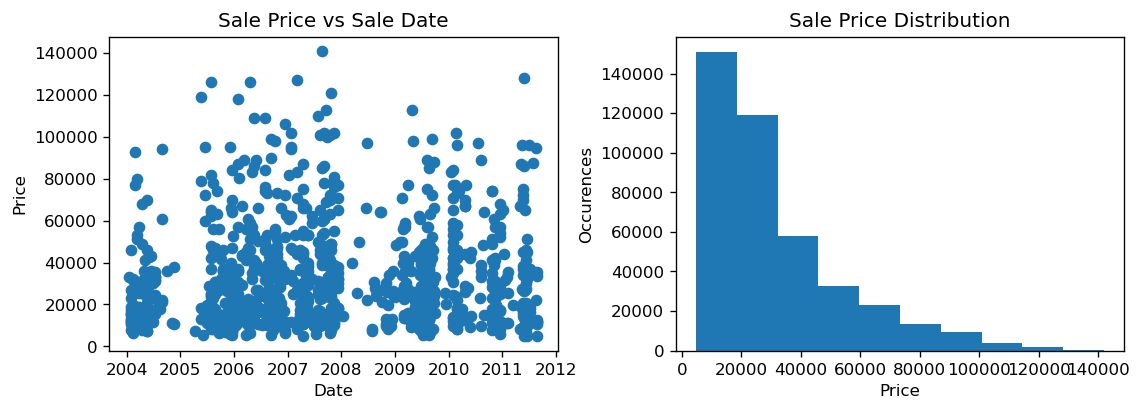

In [3]:
fig, ax = plt.subplots(nrows = 1, 
                       ncols = 2,
                       figsize=(10,4),
                       dpi=120)

fig.tight_layout(pad=4)

ax[0].scatter(data.saledate[:1000], data.SalePrice[:1000])
ax[0].set(title="Sale Price vs Sale Date",
         xlabel="Date",
         ylabel="Price")

ax[1].hist(data.SalePrice)
ax[1].set(title="Sale Price Distribution",
         xlabel="Price",
         ylabel="Occurences");

In [4]:
# Sort our data by saledate
data.sort_values(by='saledate', inplace=True)

In [5]:
# Lets take a sample of 1000 random entries to go ahead with EDA
eda_sample = data.sample(1000)

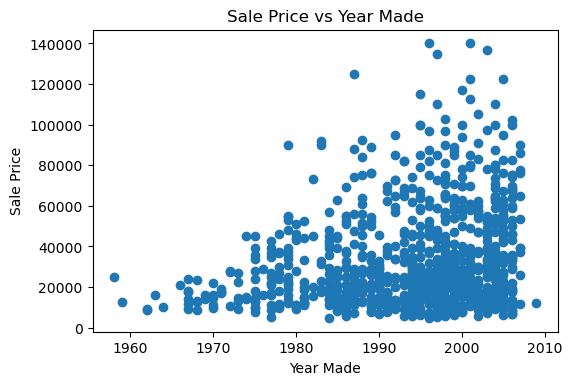

In [6]:
fig, ax = plt.subplots(figsize=(6,4), dpi=100)

# There are some rows with YearMade = 1000, what does that mean?
plot = eda_sample[eda_sample['YearMade'] > 1000]

ax.scatter(plot.YearMade, plot.SalePrice)
ax.set(title='Sale Price vs Year Made',
      xlabel='Year Made',
      ylabel='Sale Price');

<ipython-input-7-96b1f04a655a>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(plot.index, rotation=90, ha='center')


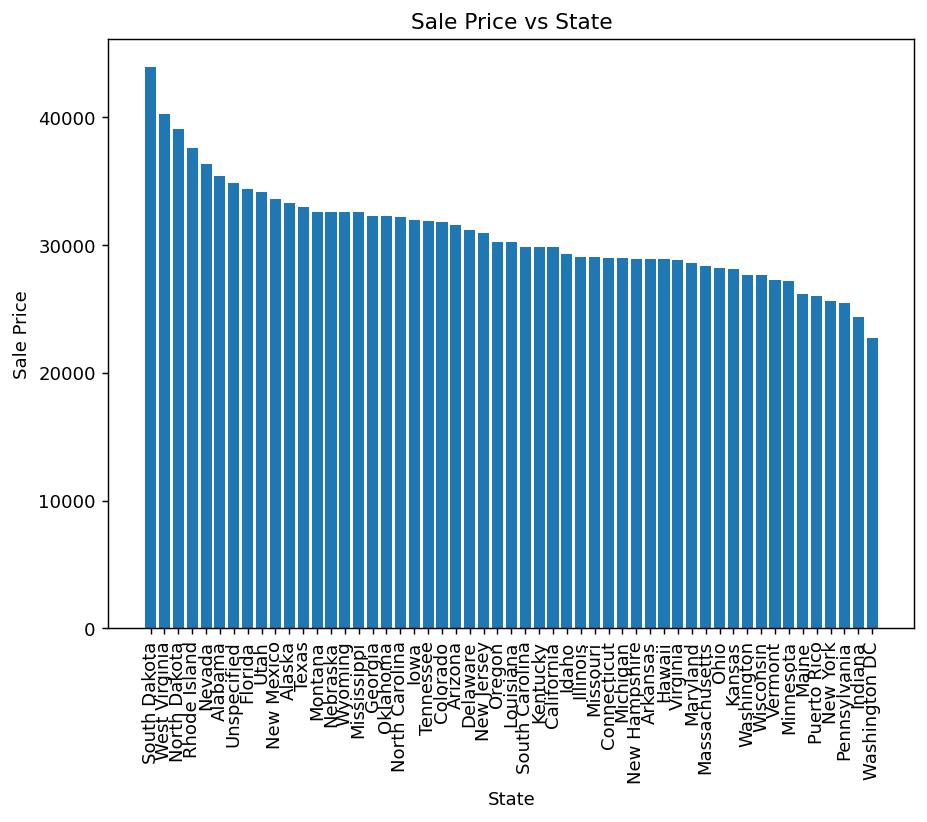

In [7]:
fig, ax = plt.subplots(figsize=(8,6), dpi=130)

plot = data.groupby('state').mean().sort_values(by='SalePrice', ascending=False)

ax.bar(plot.index, plot.SalePrice)
ax.set_xticklabels(plot.index, rotation=90, ha='center')
ax.set(title='Sale Price vs State',
      xlabel='State',
      ylabel='Sale Price');

In [8]:
# We want to enrich our date features
def enrich_data(data):
    data['SaleYear'] = data['saledate'].dt.year
    data['SaleMonth'] = data['saledate'].dt.month
    data['SaleDay'] = data['saledate'].dt.day
    data['SaleDayOfYear'] = data['saledate'].dt.dayofyear
    # Now need for this column anymore
    data = data.drop('saledate', axis=1)
    return data

data = enrich_data(data)

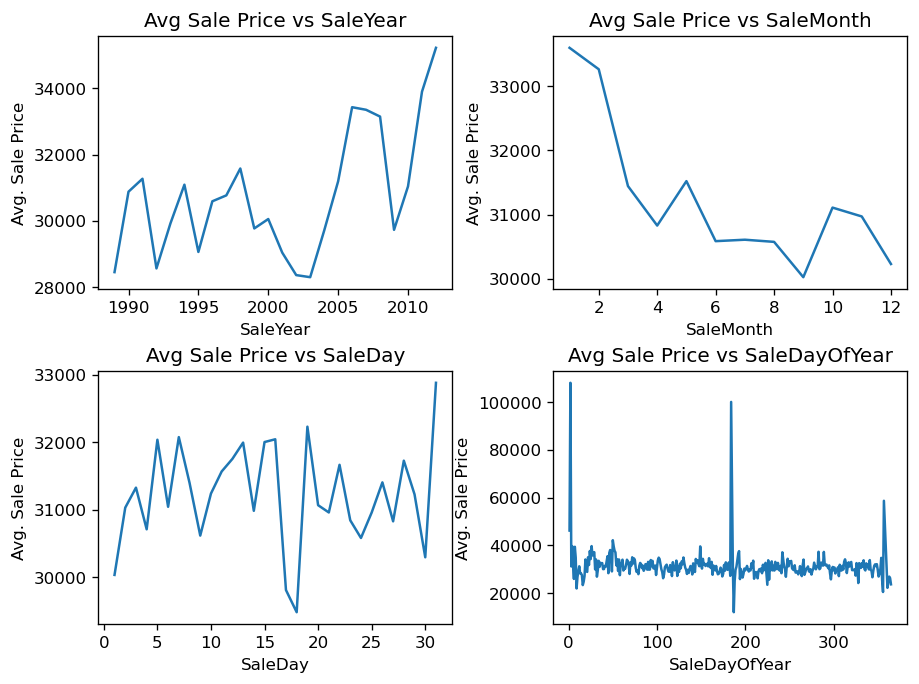

In [9]:
interest_columns = ['SaleYear', 'SaleMonth', 'SaleDay', 'SaleDayOfYear']
fig, axs = plt.subplots(ncols=2, nrows = 2, figsize = (8, 6), dpi=120)
fig.tight_layout(pad=3)
for column, ax in zip(interest_columns, axs.flat):
    plot = data.groupby(column).mean()
    ax.plot(plot.index, plot.SalePrice)
    ax.set(title=f"Avg Sale Price vs {column}",
          xlabel=f"{column}",
          ylabel="Avg. Sale Price");

## DataWrangling and Model Driven EDA

Before we can train a baseline model we need to prepare our data

In [29]:
"""
Transforms all string columns into pd.Categorical Columns
"""
def str_to_cat(dataframe):
    for label, content in dataframe.items():
        if pd.api.types.is_string_dtype(content):
            dataframe[label] = content.astype("category").cat.as_ordered()

"""
We will functionalize our datawrangling process so we can apply it to any data we want
"""
def prepare_data(data):
    clean_data = data.copy()         

    # According to our data dictionary, Null Values in the MachineHoursCurrentMeter is supposed to be 0
    clean_data.MachineHoursCurrentMeter.fillna(value=0, inplace= True)

    # There is no good way to impute the auctionerID, so we can just drop the row which don't have it as NaN
    # which is about 5% of the data
    clean_data.dropna(subset=['auctioneerID'], inplace=True)

    # Lets delete with all other columns with more than 70% of NaN values
    dropable_columns = data.columns[data.isna().sum() > data.shape[0]*0.7].values
    print(dropable_columns)
    clean_data.drop(dropable_columns, axis=1, inplace=True)
    str_to_cat(clean_data)

    # Fill categorical values (pandas uses -1 as a code for NaN, thus the +1) and add a is_missing column
    for label, content in clean_data.items():
        if not pd.api.types.is_numeric_dtype(content):
            clean_data[label+"_is_missing"] = pd.isnull(content)
            clean_data[label] = pd.Categorical(content).codes+1
    
    return clean_data

In [11]:
# Now we can train a baseline model
# Features and Target
clean_data = prepare_data(data)
x = clean_data.drop("SalePrice", axis=1)
y = clean_data["SalePrice"]

In [12]:
# Split train and test and generate a baseline model
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
baseline = RandomForestRegressor(n_jobs=3, random_state=42)

In [13]:
%time baseline.fit(x_train, y_train)

CPU times: user 4min 34s, sys: 757 ms, total: 4min 34s
Wall time: 1min 33s


RandomForestRegressor(n_jobs=3, random_state=42)

In [14]:
baseline.score(x_test, y_test)

0.9024454904467802

Okay, we got a decent score, but there is a very subtle problem with our pipeline: We are filling the missing values before splitting the data! When dealing with Time Series this could be a problem since the patterns may be changing over time, when you impute, for instance, the mean or median of a column, you are allowing information that will eventually end up in the validation set leak into the training set, the correct thing to do is to frist split the sets and then fill the values. On the other hand, we didn't use the mean or median to impute any numerical collumns (auctioneerID we just dropped, and all the inputed values where 0 as per the Data Dictionary), and the categorical values don't mind since it's safe to assume that all the categories exists in both sets, so we should be safe.

As per our introduction, the scoring on this "Competition" will be given by the RMSLE on the Test Data Set, but first, actually train the model and score it on the actual competition datasets

In [15]:
clean_data = prepare_data(data)
train_data = clean_data[clean_data.SaleYear != 2012]
valid_data = clean_data[clean_data.SaleYear == 2012]

# Competition Training Set is everything before 2012
x_train, y_train = train_data.drop("SalePrice", axis=1), train_data["SalePrice"]
# And validation is everything after
x_valid, y_valid = valid_data.drop("SalePrice", axis=1), valid_data["SalePrice"]

In [16]:
%time baseline.fit(x_train, y_train)

CPU times: user 6min 23s, sys: 756 ms, total: 6min 24s
Wall time: 2min 10s


RandomForestRegressor(n_jobs=3, random_state=42)

In [17]:
baseline.score(x_valid, y_valid)

0.8677664988095836

As we can see, splitting the data on the intended sets did lower our score quite a bit, but this is not the RMSLE

In [18]:
np.sqrt(mean_squared_log_error(y_valid, baseline.predict(x_valid)))

0.26470231581007625

In [19]:
# Lots of data, lets try reducing it a bit to speed things up a notch
grid = {
    "n_estimators": range(10,100,10),
    "min_samples_leaf": range(1,10,1),
    "min_samples_split": range(2,20,2)
}

random_cv = RandomizedSearchCV(RandomForestRegressor(n_jobs=6, 
                                                     max_samples=10000, 
                                                     random_state=42), 
                               grid, 
                               n_iter=5, 
                               verbose=1)
%time random_cv.fit(x_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   54.4s finished


CPU times: user 36.5 s, sys: 2.87 s, total: 39.4 s
Wall time: 56.7 s


RandomizedSearchCV(estimator=RandomForestRegressor(max_samples=10000, n_jobs=6,
                                                   random_state=42),
                   n_iter=5,
                   param_distributions={'min_samples_leaf': range(1, 10),
                                        'min_samples_split': range(2, 20, 2),
                                        'n_estimators': range(10, 100, 10)},
                   verbose=1)

In [23]:
# We can now train a model with these hyperparameters on the full data
best_cv_model = random_cv.best_estimator_
print(random_cv.get_params())
final_model = RandomForestRegressor(**best_cv_model.get_params())
final_model.fit(x_train, y_train)

{'cv': None, 'error_score': nan, 'estimator__bootstrap': True, 'estimator__ccp_alpha': 0.0, 'estimator__criterion': 'mse', 'estimator__max_depth': None, 'estimator__max_features': 'auto', 'estimator__max_leaf_nodes': None, 'estimator__max_samples': 10000, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_impurity_split': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__n_estimators': 100, 'estimator__n_jobs': 6, 'estimator__oob_score': False, 'estimator__random_state': 42, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': RandomForestRegressor(max_samples=10000, n_jobs=6, random_state=42), 'iid': 'deprecated', 'n_iter': 5, 'n_jobs': None, 'param_distributions': {'n_estimators': range(10, 100, 10), 'min_samples_leaf': range(1, 10), 'min_samples_split': range(2, 20, 2)}, 'pre_dispatch': '2*n_jobs', 'random_state': None, 'refit': True, 'return_train_score': False, 'scoring': None, 

RandomForestRegressor(max_samples=10000, min_samples_leaf=3,
                      min_samples_split=4, n_estimators=70, n_jobs=6,
                      random_state=42)

In [24]:
print(np.sqrt(mean_squared_log_error(y_valid, final_model.predict(x_valid))))

0.2989799128975298


In [53]:
test_data = pd.read_csv('resources/buldozer/Test.csv', parse_dates=['saledate'])
test_data.MachineHoursCurrentMeter.fillna(value=0, inplace=True)
test_data.MachineHoursCurrentMeter.isna().sum()
test_data = prepare_data(enrich_data(test_data))

['UsageBand' 'fiModelSeries' 'fiModelDescriptor' 'Drive_System' 'Pad_Type'
 'Stick' 'Turbocharged' 'Blade_Extension' 'Blade_Width' 'Enclosure_Type'
 'Engine_Horsepower' 'Pushblock' 'Ripper' 'Scarifier' 'Tip_Control'
 'Tire_Size' 'Coupler_System' 'Grouser_Tracks' 'Hydraulics_Flow'
 'Track_Type' 'Undercarriage_Pad_Width' 'Stick_Length' 'Thumb'
 'Pattern_Changer' 'Grouser_Type' 'Backhoe_Mounting' 'Blade_Type'
 'Travel_Controls' 'Differential_Type' 'Steering_Controls']


In [63]:
x_test = test_data
final_model.predict(x_test)

array([21536.13095238, 24222.61904762, 53714.16666667, ...,
       11481.20238095, 16785.05952381, 25187.19190476])